# Task 3

In this task, we are going to be working on data set of Transactions that is quite deep. We can understand what type of people do what type of transactions. Which company makes the most and which industry is booming and many more such insights using `pandas` and `numpy`.

In [4]:
# import pandas and numpy
import pandas as pd
import numpy as np

# load the data
data = pd.read_csv("./credit_card_transaction_flow.csv")

Now let's see if there are any null values in our data that may effect our calculations

In [2]:
# counting all null values
print(data.isnull().sum())

Customer ID              0
Name                     0
Surname                  0
Gender                5047
Birthdate                0
Transaction Amount       0
Date                     0
Merchant Name            0
Category                 0
dtype: int64


With that result, we can see that `5047` people did not enter their gender which is 10% of our dataset. That is quite a lot of data therefore we are going to assign them values. There are 2 ways to assign them values now.
- Use API to check whether name was of a man or woman and assign gender
- assign all nulls as others
- Use developed python library for it

For our research, let's use some API to fill as many values as we can

In [3]:
import requests
from threading import Thread

# extracting rows with no gender
customers_with_no_gender = data.drop(data[data["Gender"].notnull()].index)

# converting into array to feed into an API
names = np.array(customers_with_no_gender["Name"])[1:100]

responses = []
def getGender(name):
    req = requests.get(f"https://api.genderize.io/?name={name}")
    responses.append(req.json())

j = 0
for i in range(0, 52):
    threads = []
    while True:
        t = Thread(target=getGender, args=(names[j],))
        threads.append(t)
        t.start()
        j = j + 1
        if j % 100 == 0 or j == names.size - 1:
            break
        
    for thread in threads:
        thread.join()

    if j == names.size - 1:
        break

print(responses)

[{'error': 'Request limit reached'}, {'error': 'Request limit reached'}, {'error': 'Request limit reached'}, {'error': 'Request limit reached'}, {'error': 'Request limit reached'}, {'error': 'Request limit reached'}, {'error': 'Request limit reached'}, {'error': 'Request limit reached'}, {'error': 'Request limit reached'}, {'error': 'Request limit reached'}, {'error': 'Request limit reached'}, {'error': 'Request limit reached'}, {'error': 'Request limit reached'}, {'error': 'Request limit reached'}, {'error': 'Request limit reached'}, {'error': 'Request limit reached'}, {'error': 'Request limit reached'}, {'error': 'Request limit reached'}, {'error': 'Request limit reached'}, {'error': 'Request limit reached'}, {'error': 'Request limit reached'}, {'error': 'Request limit reached'}, {'error': 'Request limit reached'}, {'error': 'Request limit reached'}, {'error': 'Request limit reached'}, {'error': 'Request limit reached'}, {'error': 'Request limit reached'}, {'error': 'Request limit re

The given code above is just an example of how we can use API to get genders of the customers based on their names. We are using threads so we can quickly make API calls since we need to go through `5047` customers who did not provide their gender.

Using `Threads` reduces the time from expectated of `2hrs 38mins` to only `27mins`.

Now, let's use a python library removes all the load from the server and reduces our overhead of limited API calls and its restrictions and do all the processing on client side.

In [ ]:
# importing library
import gender_guesser.detector as gd

# gets the gender from the name
def infer_gender_from_name(name):
    d = gd.Detector()
    return d.get_gender(name)

# generates a list of all the genders for the names
def process_name_list(name_list):
    gender_list = [infer_gender_from_name(name) for name in name_list]
    return gender_list

# gets all the people with no gender specified
customers_with_no_gender = data.drop(data[data["Gender"].notnull()].index)
names_with_ng = pd.array(customers_with_no_gender["Name"]).tolist()

# processing using library
gender_result = process_name_list(names_with_ng)

# creating a pandas dataframe to print out a CSV
g_series = pd.DataFrame({"Gender": gender_result})
g_series.to_csv("ngc_resolved.csv")

# now generating csv for only customers with no genders specified
customers_with_no_gender.to_csv("customers_with_no_gender.csv")

In [ ]:
# now merging the two datasets to get our desired results
customers_with_no_gender = pd.read_csv("./customers_with_no_gender.csv")
customers_with_no_gender = customers_with_no_gender.iloc[::,1::]

ngc_resolved = pd.read_csv("./ngc_resolved.csv")

customers_with_no_gender["Gender"] = customers_with_no_gender["Gender"].fillna(ngc_resolved["Gender"])

data = data.dropna()
data = pd.concat([data, customers_with_no_gender])

data.to_csv("data.csv")

In [ ]:
# now cleaning up the data since our library created values like 'female', 'male' and our original values are 'F' and 'M'
data["Gender"] = data["Gender"].replace("female", "F")
data["Gender"] = data["Gender"].replace("andy", "F")
data["Gender"] = data["Gender"].replace("mostly_female", "F")
data["Gender"] = data["Gender"].replace("mostly_male", "M")
data["Gender"] = data["Gender"].replace("male", "M")

data.to_csv("data.csv")

### Cleaned Data
Now that our data is filled and has no anamolies or null values in it, we can start our statistical analysis on it and focus on how we can find data trends in it.

In [5]:
# reading cleaned up data
data = pd.read_csv("./data.csv")
data = data.iloc[::, 3::]

In [6]:
# checking which gender makes most transaction
transactions = data[["Gender", "Transaction Amount"]]
res = transactions.groupby("Gender").sum()
print(res)

        Transaction Amount
Gender                    
F              11157214.33
M              10948747.64


In [7]:
# here we can compare the two genders and see that surprisingly
# most of the numbers are almost equal to eachother in every industry
# except travelling
industries = data[["Category", "Gender", "Transaction Amount"]]
res = industries.groupby(["Category", "Gender"]).sum()
res = res.pivot_table(values="Transaction Amount", index="Gender", columns="Category")

print(res)

Category   Clothing   Cosmetic  Electronics      Market  Restaurant  \
Gender                                                                
F         659615.29  447755.10   2181257.25  1073775.38   234708.29   
M         659727.18  428917.34   2212834.85  1077359.04   229780.31   

Category      Travel  
Gender                
F         6560103.02  
M         6340128.92  


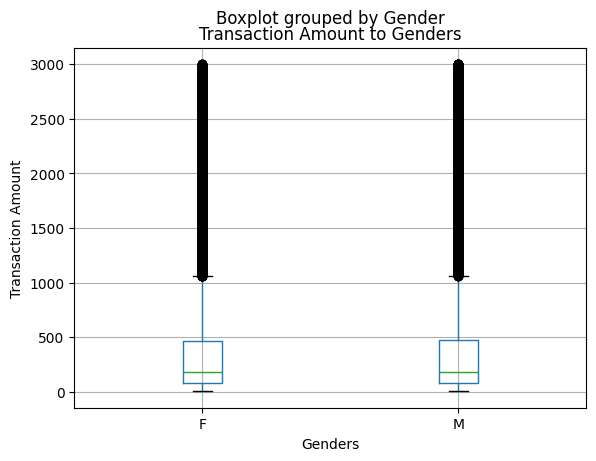

In [8]:
import matplotlib.pyplot as plt

# checking which gender makes most transaction
transactions = data[["Gender", "Transaction Amount"]]
res = transactions.groupby("Gender").sum()

fig, ax = plt.subplots()
transactions.boxplot(column='Transaction Amount', by='Gender', ax=ax)
ax.set_title('Transaction Amount to Genders')
ax.set_xlabel('Genders')
ax.set_ylabel('Transaction Amount')
plt.show()

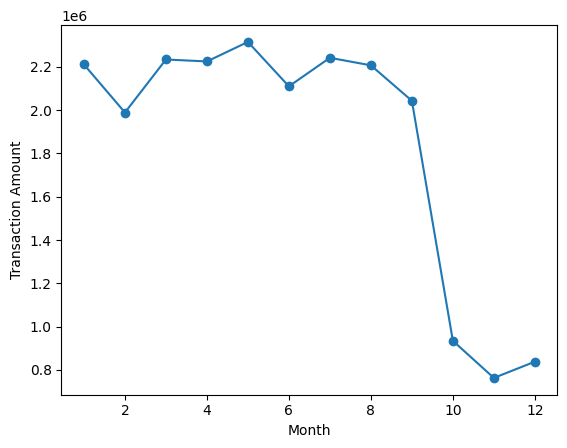

In [11]:
# checking which gender makes most transaction
dates = data[["Date", "Transaction Amount"]]
dates_column = pd.to_datetime(dates["Date"], format='mixed')
dates = dates.assign(Day=dates_column.dt.day, Month=dates_column.dt.month, Year=dates_column.dt.year)
dates = dates.drop("Date", axis=1)
grouped_month = dates[["Month", "Transaction Amount"]].groupby("Month").sum()

grouped_month = grouped_month.reset_index()
plt.plot(grouped_month["Month"], grouped_month["Transaction Amount"], marker='o')
plt.xlabel("Month")
plt.ylabel("Transaction Amount")
plt.show()

From The above graph we can see that in the last quarter there is very low transactions as compared to the rest of the year. And in the middle of the year we see the transaction amount going up and this quite possible because of `Summer Vacations` and all the sales we see during those months.

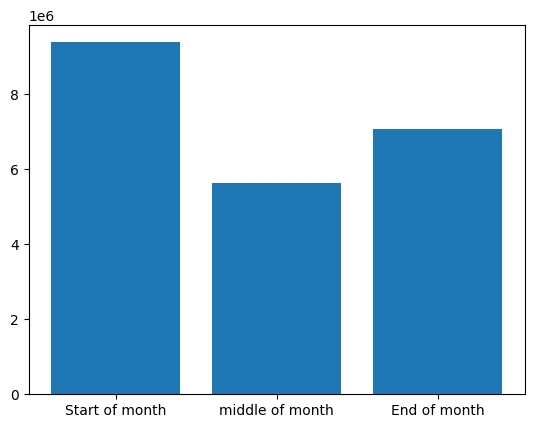

In [12]:
dates["Day_Group"] = pd.cut(dates["Day"], [0,10,20,31], labels=["Start of month", "middle of month", "End of month"])

grouped_data = dates[["Day_Group", "Transaction Amount"]].groupby("Day_Group", observed=False).sum().reset_index()
plt.bar(x=grouped_data["Day_Group"], height=grouped_data["Transaction Amount"])
plt.show()

From the above data we can see that most people spend their money in the starting of the month and that is probably due to the fact that their wage is sent out in the starting of the month